In [1]:
# Set working directory (optional during development)
import os
os.chdir('/Users/sudishmakarki/My_project2')  # only if needed
print(" Working directory:", os.getcwd())

# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from prophet.diagnostics import cross_validation, performance_metrics

# Custom Functions
from models.data_interpolation import (
    load_data,
    preprocess_data,
    split_train_test,
    generate_time_series_splits
)

from models.model_sarimax import (
    prepare_sarimax_data,
    check_stationarity,
    plot_acf_pacf,
    fit_sarimax_model,
    analyze_residual_spike,
    ljung_box_test,
    forecast_sarimax_model,
    identify_peak_hours_sarimax,
    evaluate_sarimax_metrics,
    rolling_forecast_sarimax,
    
)

 Working directory: /Users/sudishmakarki/My_project2


In [2]:
# Load and preprocess
df = load_data('data/RestaurantData.csv')
df_clean = preprocess_data(df)

                     Year  Month  Season  DayOfWeek WeekDay  Hour  \
Timestamp                                                           
2018-01-01 00:00:00  2018      1  Winter          1  Monday     0   
2018-01-01 01:00:00  2018      1  Winter          1  Monday     1   
2018-01-01 02:00:00  2018      1  Winter          1  Monday     2   
2018-01-01 03:00:00  2018      1  Winter          1  Monday     3   
2018-01-01 04:00:00  2018      1  Winter          1  Monday     4   

                            Holiday Weather SpecialEvent  CustomerCount  \
Timestamp                                                                 
2018-01-01 00:00:00  New Year's Day   Rainy          NaN              6   
2018-01-01 01:00:00  New Year's Day   Windy          NaN             11   
2018-01-01 02:00:00  New Year's Day   Snowy          NaN              9   
2018-01-01 03:00:00  New Year's Day   Rainy          NaN             10   
2018-01-01 04:00:00  New Year's Day  Cloudy          NaN          

In [3]:
# Split into train and test
restaurant_train, restaurant_test = split_train_test(df_clean, split_date='2022-01-01')
# Format for SARIMAX
train_series, test_series = prepare_sarimax_data(restaurant_train, restaurant_test)

Baseline Model for SARIMAX

ADF Statistic: -15.026219911968534
p-value: 1.00551216199881e-27
Result: Stationary


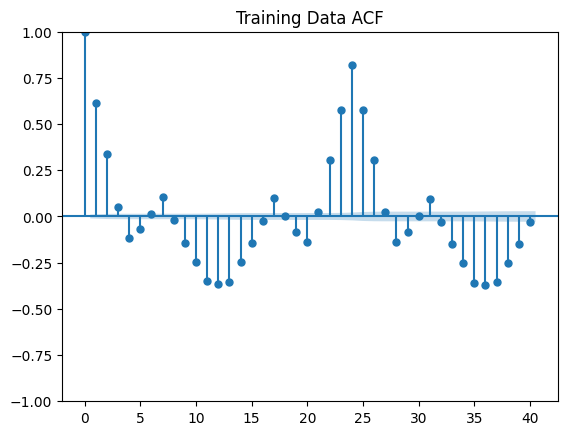

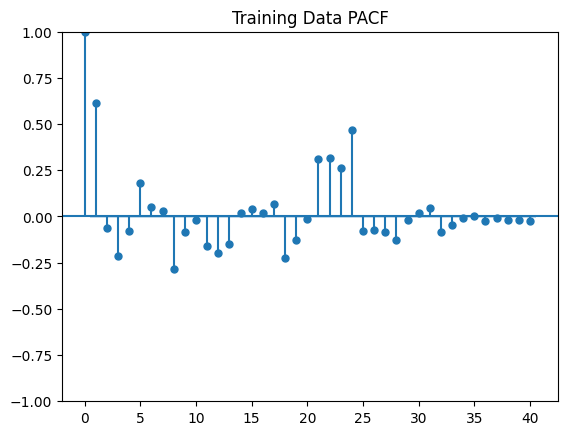

In [ ]:
# --- Stationarity Check & ACF/PACF ---
check_stationarity(train_series)
plot_acf_pacf(train_series, lags=40, title_prefix="Training Data")

In [ ]:
# --- Fit SARIMAX Baseline Model ---
results_sarimax = fit_sarimax_model(train_series)

                                     SARIMAX Results                                      
Dep. Variable:                      CustomerCount   No. Observations:                35064
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood             -114396.022
Date:                            Thu, 10 Apr 2025   AIC                         228802.044
Time:                                    13:12:59   BIC                         228844.365
Sample:                                01-01-2018   HQIC                        228815.524
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1368      0.005     25.681      0.000       0.126       0.147
ma.L1         -0.9423      0.002   

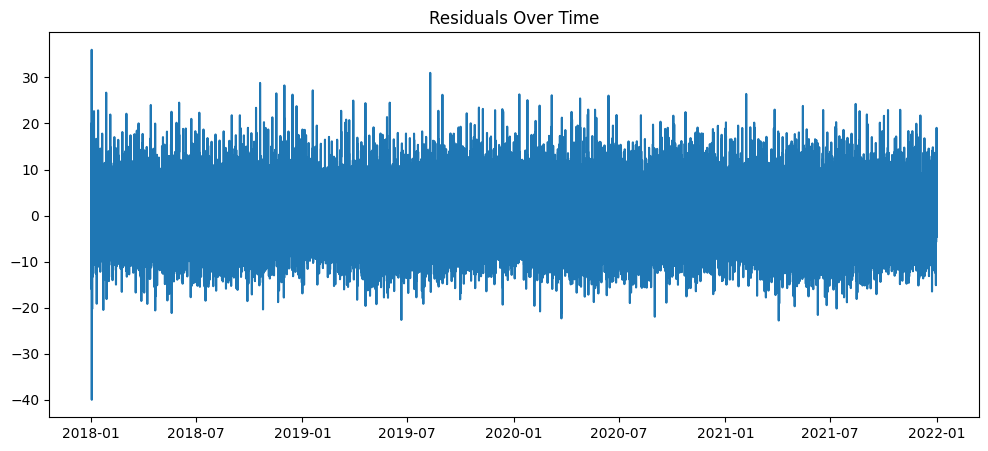

In [ ]:
# -- Residual Analysis ---
residuals = results_sarimax.resid

# Residual plot + ACF/PACF
plt.figure(figsize=(12, 5))
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.show()

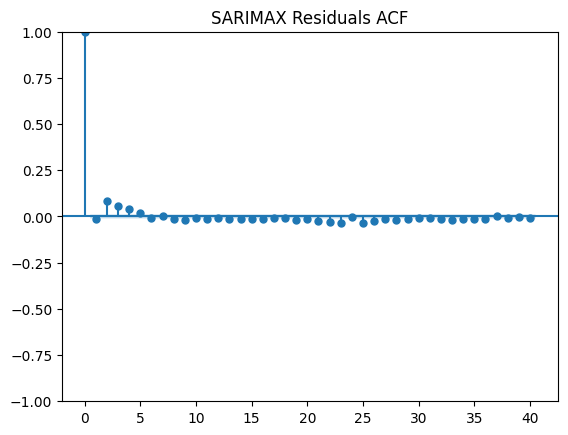

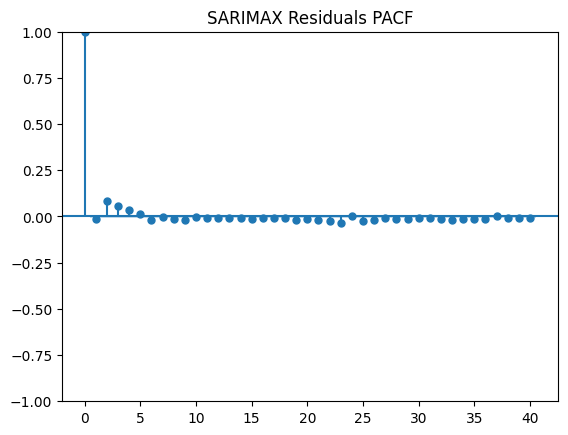

In [7]:
plot_acf_pacf(residuals, lags=40, title_prefix="SARIMAX Residuals")


In [10]:
# Residual spike + Ljung-Box
analyze_residual_spike(residuals, train_series.to_frame(name="CustomerCount/n"))
ljung_box_test(residuals)

Largest residual at: 2018-01-01 22:00:00
Residual value: -39.99965833176916

Data at the timestamp with the largest residual:
CustomerCount/n    9
Name: 2018-01-01 22:00:00, dtype: int64
Ljung-Box test results:
       lb_stat     lb_pvalue
10  436.673183  1.451813e-87


,lb_stat,lb_pvalue
10,436.673183,1.451813e-87


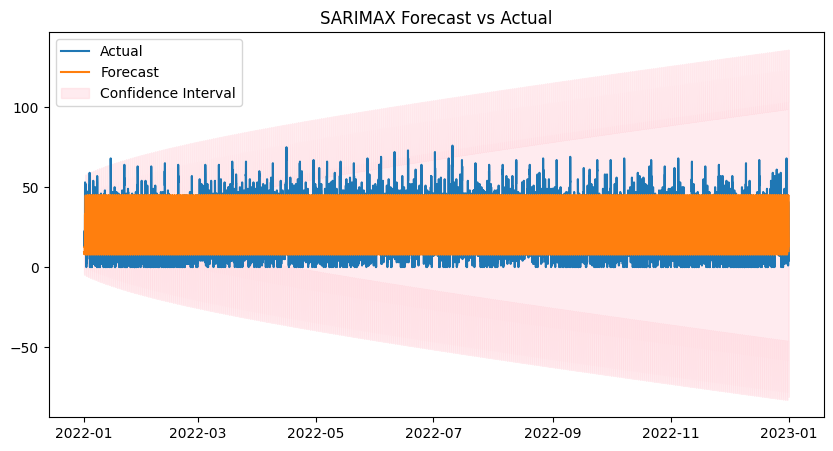

In [ ]:
# --- Forecast on Test Set ---
forecast_mean, forecast_ci = forecast_sarimax_model(results_sarimax, len(test_series), test_index=test_series.index)
forecast_mean.head()
forecast_ci.head()

# --- Overall Forecast vs Actual --
plt.figure(figsize=(12, 6))
plt.plot(train_series.index, train_series, label='Training Data', color='steelblue')
plt.plot(test_series.index, test_series, label='Actual Test Data', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='SARIMAX Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title("SARIMAX Forecast vs Actual (Overall)")
plt.xlabel("Time")
plt.ylabel("CustomerCount")
plt.legend()
plt.show()